# Notebook 2.6.2: Epidemiology (Iteration and Analysis)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
# These functions are what we used to run an simulation with immunization

import pandas as pd
import numpy as np

def make_system(iS,iI,iR,tc,tr,t_end,t_imm,p_imm):
    ''' Makes a system for a KM model problem.

    iS: Initial susceptible population (as an integer)
    iI: Initial infected population (as an integer)
    iR: Initial recovered population (as an integer)
    tc: Days between potentially infecting contacts
    tr: Average recovery time, in days
    t_end: the length of time of the simulation in days
    t_imm: the time (day number) when immunization occurs
    p_imm: the percent of population (all susceptible) that is immunized
    
    return: a dictionary holding the system parameters'''
    N = iS + iI + iR
    iS = iS/N
    iI = iI/N
    iR = iR/N
    beta = 1/tc
    gamma = 1/tr
    return dict(iS=iS, iI=iI, iR=iR, N=N, beta=beta, gamma=gamma,
                t_end=t_end, t_imm=t_imm, p_imm=p_imm)
    
def make_state(system):
    state = pd.Series(dict(s=system['iS'], i=system['iI'], r=system['iR']),name="State Variables")
    return state

def change_func(t, state, system):
    if t == system['t_imm']:
        state = add_immunization(state,system)

    s, i, r = state.s, state.i, state.r
        
    infected = system['beta'] * i * s    
    recovered = system['gamma'] * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return pd.Series(dict(s=s, i=i, r=r),name="State Variables")

def run_simulation(system, change_func):
    state = make_state(system)
    frame = pd.DataFrame([],columns=state.index)
    frame.loc[0] = state
    
    for t in range(0, system['t_end']):
        frame.loc[t+1] = change_func(t, frame.loc[t], system)
    
    return frame

def add_immunization(state,system):
    state.s -= system['p_imm']
    state.r += system['p_imm']
    return state


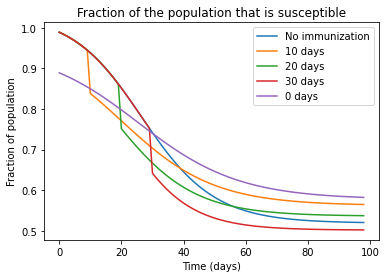

In [ ]:
iS = 89; iI = 1; iR = 0    
tc = 3; tr = 4; t_end = 14*7
t_imm = 0; p_imm = 0.0

system = make_system(iS,iI,iR,tc,tr,t_end,t_imm,p_imm)
results = run_simulation(system, change_func)

t_imm = 0; p_imm = 0.1

system2 = make_system(iS,iI,iR,tc,tr,t_end,t_imm,p_imm)
results2 = run_simulation(system2, change_func)

t_imm = 10; p_imm = 0.1

system3 = make_system(iS,iI,iR,tc,tr,t_end,t_imm,p_imm)
results3 = run_simulation(system3, change_func)

t_imm = 20; p_imm = 0.1

system4 = make_system(iS,iI,iR,tc,tr,t_end,t_imm,p_imm)
results4 = run_simulation(system4, change_func)

t_imm = 30; p_imm = 0.1

system5 = make_system(iS,iI,iR,tc,tr,t_end,t_imm,p_imm)
results5 = run_simulation(system5, change_func)

results.s.plot(label='No immunization', legend=True)
results3.s.plot(label='10 days', legend=True)
results4.s.plot(label='20 days',legend=True)
#results5.s.plot(label='30 days',legend=True)
results2.s.plot(label='0 days',
                title='Fraction of the population that is susceptible',
                xlabel='Time (days)',
                ylabel='Fraction of population',legend=True);


In [ ]:
# These are the functions  and runtime code
# we used to sweep across immunization rates
def calc_total_infected(results, system):
    s_0 = results.s[0]
    s_end = results.s[system['t_end']]
    s_immunized = 0
    if system['t_imm'] > 0:
        s_immunized = system['p_imm']
    return s_0 - s_end - s_immunized

def sweep_time_imm(system,time_array):
    sweep = pd.Series([],dtype=object)
    
    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS']*N, system['iI']*N,system['iR']*N
    tc, tr = 1/system['beta'], 1/system['gamma']
    t_end, p_imm = system['t_end'], system['p_imm']

    for t_imm in time_array:
        system_local = make_system(iS,iI,iR,tc,tr,t_end,t_imm,p_imm)
        results = run_simulation(system_local, change_func)
        sweep[t_imm] = calc_total_infected(results, system_local)

    return sweep


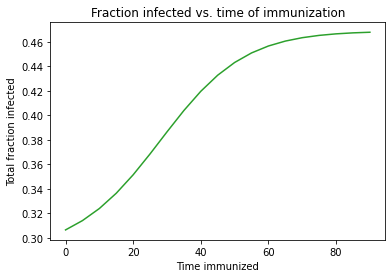

In [ ]:
iS = 89; iI = 1; iR = 0    
tc = 3; tr = 4; t_end = 14*7
p_imm = 0.1

system = make_system(iS,iI,iR,tc,tr,t_end,t_imm,p_imm)
time_array = np.linspace(0, 90, 19)

infected_sweep = sweep_time_imm(system, time_array)
infected_sweep.plot(color='C2',xlabel='Time immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. time of immunization');